Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from skimage import transform
import numpy as np
import pywt
from torch.utils.data import Dataset
import PIL.Image as Image

# !pip install datasets==2.15
# import datasets

# !pip install kornia
# import kornia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

WaveMixSR

In [2]:
class Level1Waveblock(nn.Module):
    def __init__(self, c):
        super(Level1Waveblock, self).__init__()
        self.conv = nn.Conv2d(c, c // 4, 3,padding = 1)
        self.feedforward = nn.Sequential(
            nn.Conv2d(c, c, 1),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Conv2d(c, c, 1),
            nn.ConvTranspose2d( c, c, 4, stride=2, padding=1),
            nn.BatchNorm2d(c)
        )


    def haar_wavelet_transform(self, x):
        batch_size, coefficients = x.size(0), []

        for i in range(batch_size):
            image = x[i]
            image_np = image.detach().cpu().numpy()
            image_coefficients = []

            for channel in image_np:
                aa,(ad,da,dd) = pywt.dwt2(channel, 'haar')
                image_coefficients.append(aa)
                image_coefficients.append(ad)
                image_coefficients.append(da)
                image_coefficients.append(dd)

            coefficients.append(image_coefficients)

        return torch.tensor(np.array(coefficients)).to(device)

    def forward(self, x):
        x = self.conv(x)
        x = self.haar_wavelet_transform(x)
        x = self.feedforward(x)
        return x.to(device)

In [49]:
import torch.nn as nn
import torchvision.models as models

class WaveMixSR(nn.Module):
    def __init__(self, depth, c):
        super(WaveMixSR, self).__init__()
        resnet18 = models.resnet18().to(device)
        
        # Load the pre-trained weights from the given path
        pre_trained_weights = torch.load("/kaggle/input/resnet18/resnet18-f37072fd.pth")
        resnet18.load_state_dict(pre_trained_weights)

        # Get the first three layers from VGG11
        self.resnet_layers = nn.Sequential(
            resnet18.conv1,   # First convolutional layer
            resnet18.bn1,     # Batch normalization layer
            resnet18.relu,    # ReLU activation function
            resnet18.maxpool,  # Max pooling layer
            resnet18.layer1,  # The first residual block
            resnet18.layer2  # The second residual block
        ).to(device)

        # WaveMixSR layers
        self.layers = nn.ModuleList([Level1Waveblock(c) for _ in range(depth)])

        self.final = nn.Sequential(
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.Conv2d(16, 8, 3, stride=1, padding=1),
            nn.Conv2d(8, 3, 3, stride=1, padding=1),
        )

        # Use VGG11's initial layers in self.path1
        self.path1 = nn.Sequential(
            nn.Upsample(scale_factor=7, mode='bicubic', align_corners=False),
            self.resnet_layers,  # Use VGG11's first three layers
        )

    def forward(self, img):
        
        y = self.path1(img)
        
        # Apply WaveMixSR layers
        for layer in self.layers:
            y = layer(y) + y
            
        
        # Final transformation to convert back to 1-channel
        y = self.final(y)
        
        resize_transform = transforms.Resize((128, 128))

        # Apply the transformation
        img_resized = resize_transform(y)

        # Concatenate the Y and CrCb components
        return img_resized.to(device)

Loss

In [43]:
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(torch.sqrt(torch.abs(torch.max(img1)))/ torch.sqrt(mse)).to('cuda')

class PSNRLoss(torch.nn.Module):
    def __init__(self):
        super(PSNRLoss, self).__init__()

    def forward(self, img1, img2):
        return -psnr(img1, img2).to(device)

In [44]:
import torch
import torch.nn.functional as F
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Function to compute SSIM between two tensors
def ssim_pytorch(img1, img2):
    # Convert PyTorch tensors to NumPy arrays for SSIM computation
    # We detach tensors from computation graph to avoid gradients-related issues
    img1_np = img1.detach().cpu().numpy()
    img2_np = img2.detach().cpu().numpy()
    
    # Compute SSIM for each image in the batch
    ssim_value = 0.0
    batch_size = img1_np.shape[0]
    for i in range(batch_size):
        ssim_value_batch, _ = ssim(img1_np[i], img2_np[i], full=True, channel_axis=2)  # Assuming PyTorch format (N, C, H, W)
        ssim_value += ssim_value_batch
    
    # Return the mean SSIM value for the batch
    return ssim_value / batch_size

# Define SSIM Loss class
class SSIMLoss(torch.nn.Module):
    def __init__(self):
        super(SSIMLoss, self).__init__()

    def forward(self, img1, img2):
        # Compute SSIM and return 1 - SSIM as the loss value
        ssim_val = ssim_pytorch(img1, img2)
        ssim_loss = 1.0 - ssim_val
        return ssim_loss

Dataset

In [57]:
from keras.datasets import mnist
from keras.utils import to_categorical
from PIL import Image

class SuperResolutionDataset(Dataset):
    def __init__(self, dataset, upscale_factor):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]
        img_pil = Image.fromarray(img.astype('uint8'))
        img_ycbcr = img_pil.convert('YCbCr')
        lr_img = self.transform(img_ycbcr)
        hr_img = transforms.ToTensor()(img_ycbcr)

        return lr_img, hr_img

# (train_X, _), (test_X, _) = mnist.load_data()

import os
from sklearn.model_selection import train_test_split

image_dir = '/kaggle/input/dataset/flowers/flowers'
image_files = np.array([Image.open(os.path.join(image_dir, file)) for file in os.listdir(image_dir)])
train_X, test_X = train_test_split(image_files, test_size=0.2, random_state=42)

upscale_factor = 2

train_dataset = SuperResolutionDataset(train_X[0:500], upscale_factor)
test_dataset = SuperResolutionDataset(test_X[0:100], upscale_factor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

Model

In [61]:
model = WaveMixSR(depth=4, c=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = PSNRLoss()

Training

In [69]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = loss_function(outputs, targets.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

Epoch 1/20, Loss: -37.583697805760806
Epoch 2/20, Loss: -37.84997343324527
Epoch 3/20, Loss: -37.870842264895614
Epoch 4/20, Loss: -37.594273230841544
Epoch 5/20, Loss: -37.834345552436545
Epoch 6/20, Loss: -38.0160979116606
Epoch 7/20, Loss: -37.77064226870715
Epoch 8/20, Loss: -37.75871355998566
Epoch 9/20, Loss: -37.78397872734861
Epoch 10/20, Loss: -38.048887672266034
Epoch 11/20, Loss: -37.89468449477833
Epoch 12/20, Loss: -38.138315905179226
Epoch 13/20, Loss: -37.80879634049918
Epoch 14/20, Loss: -38.059155824273454
Epoch 15/20, Loss: -37.63055912983368
Epoch 16/20, Loss: -37.07459372999263
Epoch 17/20, Loss: -37.900705313781486
Epoch 18/20, Loss: -37.75007756814917
Epoch 19/20, Loss: -37.38679460074397
Epoch 20/20, Loss: -37.97565354153328


Testing

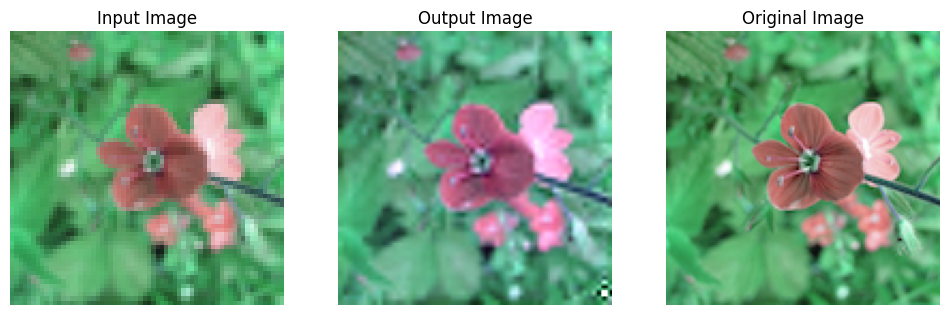

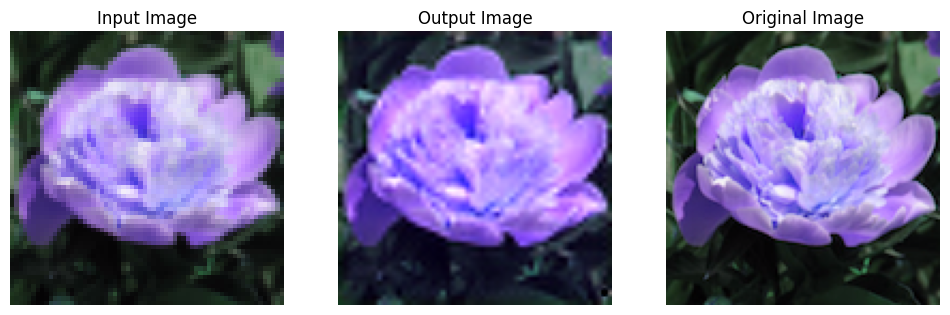

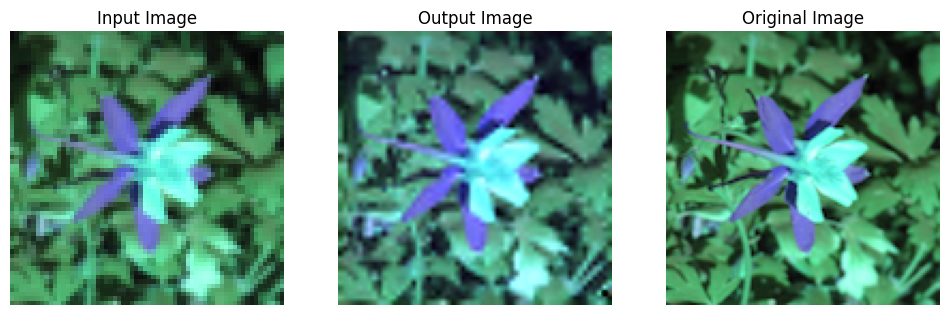

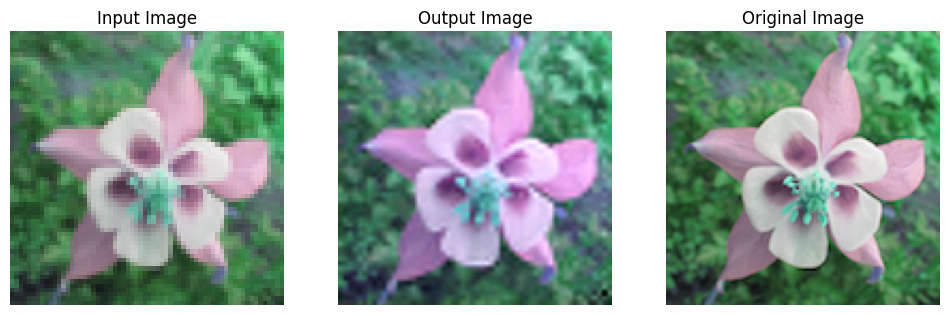

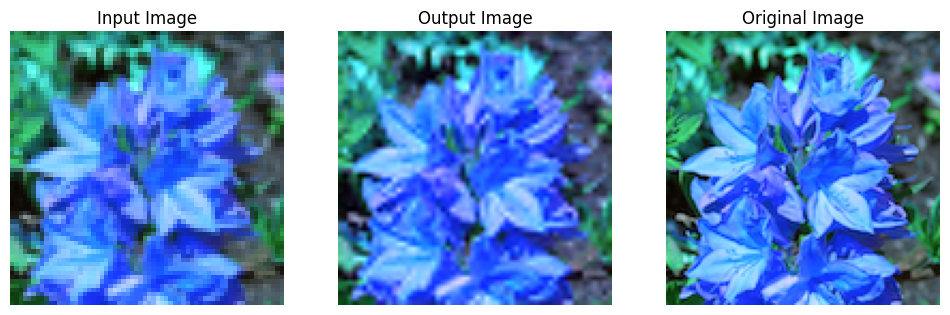

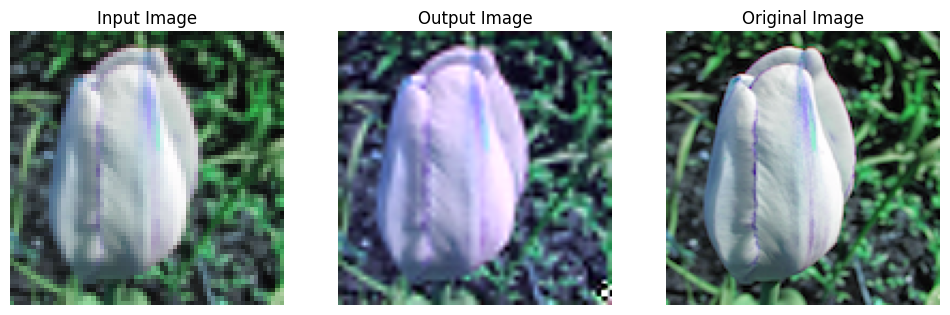

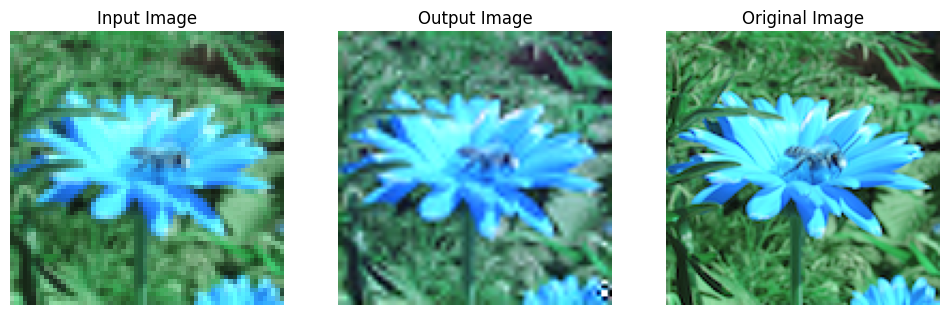

Average PSNR on test set: 35.68909345354353


In [70]:
import matplotlib.pyplot as plt
import cv2

model.eval()
total_psnr = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.to(device))
        psnr_value = psnr(outputs, targets.to(device))
        total_psnr += psnr_value.item()

        input_image = inputs[0].permute(1, 2, 0).cpu().numpy()
        output_image = outputs[0].permute(1, 2, 0).cpu().numpy()
        target_image = targets[0].permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Output Image')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_YCrCb2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.show()

average_psnr = total_psnr / len(test_loader)
print(f"Average PSNR on test set: {average_psnr}")